# Testing different Hyperparameters and Benchmarking

Lets say we want to learn more about __how different learning rates and different image sizes affect our model's accuracy when restricted to 10 epochs__, and we want to build an experiment to test out these hyperparameters.

In this notebook, we'll walk through how we use out Parameter Sweeper module with the following:

- use python to perform this experiment
- use the CLI to perform this experiment
- evalute the results using Pandas

We start by importing the utilities we need.

In [2]:
import sys
sys.path.append("../")
import os

from utils_ic.common import ic_root_path
from utils_ic.datasets import unzip_url, Urls
from utils_ic.parameter_sweeper import *

Lets download some data that we want to test on. To use the Parameter Sweeper tool for single label classification, we'll need to make sure that the data is stored such that images are sorted into their classes inside of a subfolder. In this notebook, we'll use the Fridge Objects dataset provided in `utils_ic.datasets.Urls`, which is stored in the correct format.

In [3]:
input_data = unzip_url(Urls.fridge_objects_path, exist_ok=True)

## Using Python

We start by creating the Parameter Sweeper object:

In [4]:
sweeper = ParameterSweeper()

Before we start testing, it's a good idea to see what the default parameters Are. We can use a the property `parameters` to easily see those default values.

In [5]:
sweeper.parameters

OrderedDict([('learning_rate', [0.0001]),
             ('epochs', [15]),
             ('batch_size', [16]),
             ('im_size', [299]),
             ('architecture',
              [<Architecture.resnet18: functools.partial(<function resnet18 at 0x7f78e95840d0>)>]),
             ('transform', [True]),
             ('dropout', [0.5]),
             ('weight_decay', [0.01]),
             ('training_schedule',
              [<TrainingSchedule.head_first_then_body: 'head_first_then_body'>]),
             ('discriminative_lr', [False]),
             ('one_cycle_policy', [True])])

Now that we know the defaults, we can pass it the parameters we want to test. 

In this notebook, we want to see the effect of different learning rates across different image sizes using only 8 epochs (the default number of epochs is 15). To do so, I would run the `update_parameters` functions as follows:

```python
sweeper.update_parameters(learning_rate=[1e-3, 1e-4, 1e-5], im_size=[299, 499], epochs=[10])
```

Notice that all parameters must be passed in as a list, including single values such the number of epochs.

These parameters will be used to calculate the number of permutations to run. In this case, we've pass in three options for learning rates, two for image sizes, and one for number of epochs. This will result in 3 X 2 X 1 total permutations (in otherwords, 6 permutations). 

In [12]:
sweeper.update_parameters(learning_rate=[1e-2], im_size=[299], epochs=[10])

Now that we have our parameters defined, we call the `run()` function with the dataset to test on. 

We can also optionally pass in:
- the number of repetitions to run each permutation (default is 3)
- whether or not we want the training to stop early if the metric (accuracy) doesn't improve by 0.01 (1%) over 3 epochs (default is False)

The `run` function returns a multi-index dataframe which we can work with right away.

In [13]:
df = sweeper.run(datasets=unzip_urls(Urls.all()), reps=1)

this Learner object self-destroyed - it still exists, but no longer usable


## Using the CLI

Instead of using python to run this experiment, we may want to test from the CLI. We can do so by using the `scripts/benchmark.py` file. 

First we move up to the `/image_classification` directory.

In [7]:
os.chdir(ic_root_path())

To reproduce the same test (different learning rates across different image sizes using only 8 epochs), and the same settings (3 repetitions, and no early_stopping) we can run the following:

```sh
python scripts/sweep.py 
    --learning-rates 1e-3 1e-4 1e-5
    --im-size 99 299
    --epochs 5 
    --repeat 3 
    --no-early-stopping 
    --inputs <my-data-dir>
    --output lr_bs_test.csv
```

Additionally, we've added an output parameter, which will automatically dump our dataframe into a csv file.

To simplify the command, we can use the acryonyms of the params. We can also remove `--no-early-stopping` as that is the default behavior.

```sh
python scripts/sweep.py -lr 1e-3 1e-4 1e-5 -is 99 299 -e 5 -i <my-data-dir> -o lr_bs_test.csv
```

In [8]:
# use {sys.executable} instead of just running `python` to ensure the command is executed using the environment cvbp
!{sys.executable} scripts/sweep.py -lr 1e-3 1e-4 1e-5 -is 99 299 -e 5 -i {input_data} -o data/lr_bs_test.csv

Once the script completes, load the csv into a dataframe to explore it's contents. We'll want to specify `index_col=[0, 1, 2]` since it is a multi-index dataframe.

```python
df = pd.read_csv("data/lr_bs_test.csv", index_col=[0, 1, 2])
```

HINT: You can learn more about how to use the script with the `--help` flag.

In [14]:
!{sys.executable} scripts/sweep.py --help

usage: sweep.py [-h] [--learning-rate LEARNING_RATES [LEARNING_RATES ...]]
                [--epoch EPOCHS [EPOCHS ...]]
                [--batch-size BATCH_SIZES [BATCH_SIZES ...]]
                [--im-size IM_SIZES [IM_SIZES ...]]
                [--architecture {squeezenet1_1,resnet18,resnet34,resnet50} [{squeezenet1_1,resnet18,resnet34,resnet50} ...]]
                [--transform TRANSFORMS [TRANSFORMS ...]]
                [--dropout DROPOUTS [DROPOUTS ...]]
                [--weight-decay WEIGHT_DECAYS [WEIGHT_DECAYS ...]]
                [--training-schedule {head_only,body_only,head_first_then_body} [{head_only,body_only,head_first_then_body} ...]]
                [--discriminative-lr {True,False} [{True,False} ...]]
                [--one-cycle-policy ONE_CYCLE_POLICIES [ONE_CYCLE_POLICIES ...]]
                (--inputs INPUTS [INPUTS ...] | --benchmark)
                [--early-stopping] [--repeat REPEAT] [--output OUTPUT]
                [--clean-up]

This script is used t

---

## Visualizing our results

When we read in out multi-index dataframe, index 0 represents the run number, index 1 represents a single permutation of parameters, and index 2 represents the dataset.

To see the results, show the df using the `clean_df` helper function. This will display all the hyperparameters in a nice, readable way.

In [14]:
df = clean_sweeper_df(df); df 

duration  accuracy
0 P: fashionTexture       208.451069  0.249117
     flickrLogos32Subset  268.697510  0.217920
     food101Subset        193.297698  0.689091
     fridgeObjects         16.846054  0.272727
     lettuce               22.276844  0.632000
     recycle_v3            62.554605  0.766129

Since we've run our benchmarking over 3 repetitions, we may want to just look at the averages across the different __run numbers__.

In [16]:
df.mean(level=(1,2)).T

,P: [learning_rate: 0.0001] [im_size: 299],P: [learning_rate: 0.0001] [im_size: 499],P: [learning_rate: 0.001] [im_size: 299],P: [learning_rate: 0.001] [im_size: 499],P: [learning_rate: 1e-05] [im_size: 299],P: [learning_rate: 1e-05] [im_size: 499]
,fridgeObjects,fridgeObjects,fridgeObjects,fridgeObjects,fridgeObjects,fridgeObjects
duration,16.790272,26.111746,18.401948,26.436082,16.929840,26.340579
accuracy,0.856061,0.901515,0.909091,0.871212,0.371212,0.409091


Additionally, we may want simply to see which set of hyperparameters perform the best across the different __datasets__. We can do that by averaging the results of the different datasets. (The results of this step will look similar to the above since we're only passing in one dataset).

In [17]:
df.mean(level=(1)).T

,P: [learning_rate: 0.0001] [im_size: 299],P: [learning_rate: 0.0001] [im_size: 499],P: [learning_rate: 0.001] [im_size: 299],P: [learning_rate: 0.001] [im_size: 499],P: [learning_rate: 1e-05] [im_size: 299],P: [learning_rate: 1e-05] [im_size: 499]
duration,16.790272,26.111746,18.401948,26.436082,16.929840,26.340579
accuracy,0.856061,0.901515,0.909091,0.871212,0.371212,0.409091


To make it easier to see which permutation did the best, we can plot the results using the `plot_df` helper function. This plot will help us easily see which parameters offer the highest accuracies.

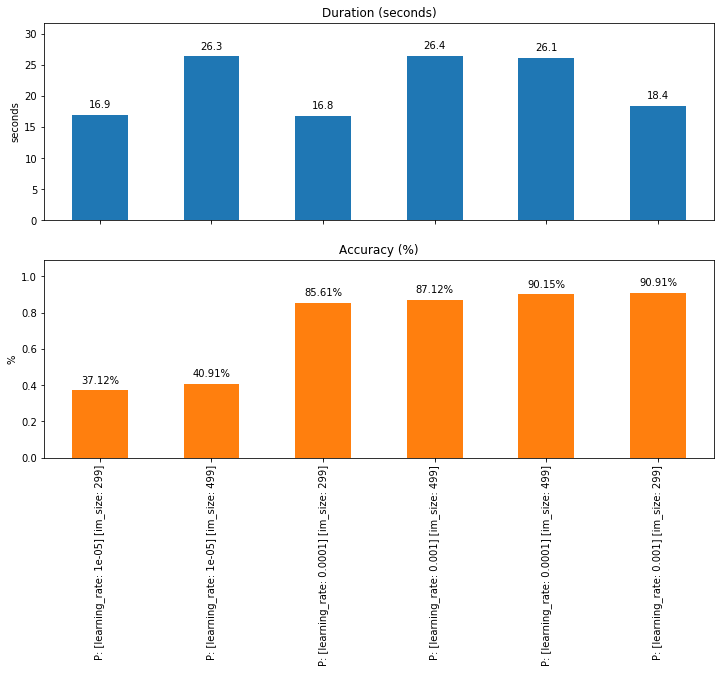

In [18]:
plot_sweeper_df(df.mean(level=(1)), sort_by="accuracy")

---

# Benchmarking

We can also use the Parameter Sweeper to perform some benchmarking on different paramters. Instead of passing in a single dataset, we can use a grouping of datasets (which we can simply get from `unzip_urls(Urls.all())`) so that we can tell how well the paramters do across different datasets.

In [2]:
benchmark_data = unzip_urls(Urls.all())

In [3]:
benchmarking_sweeper = ParameterSweeper()

In [4]:
benchmarking_sweeper.update_parameters(learning_rate=[1e-2, 1e-3, 1e-4, 1e-5, 1e-6], epochs=[3])

In [24]:
df = benchmarking_sweeper.run(datasets=benchmark_data, reps=5)

this Learner object self-destroyed - it still exists, but no longer usable


In [5]:
# df = pd.read_csv("lr_df_epoch_3_01.csv", index_col=[0, 1, 2])

In [6]:
df = clean_sweeper_df(df)

[Text(0, 0, '0.00%'),
 Text(0, 0, '20.00%'),
 Text(0, 0, '40.00%'),
 Text(0, 0, '60.00%'),
 Text(0, 0, '80.00%'),
 Text(0, 0, '100.00%'),
 Text(0, 0, '120.00%')]

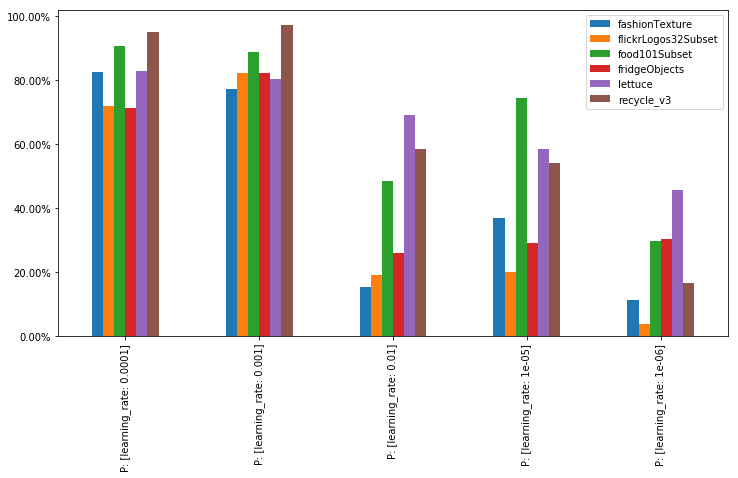

In [8]:
ax = df.mean(level=(1,2))["accuracy"].unstack().plot(kind='bar', figsize=(12, 6))
ax.set_yticklabels(['{:,.2%}'.format(x) for x in ax.get_yticks()])